In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall -y -q tsfresh fastai spacy thinc catalogue confection \
    numpy scipy gensim scikit-learn

!pip install -Uq \
    "numpy<2.0" \
    "scipy<1.13" \
    "scikit-learn<1.7" \
    "gensim==4.3.2" \
    "bertopic==0.17.0" \
    umap-learn hdbscan sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -U kaleido
 # <-- 1× saja; abaikan kalau sudah ada

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 4.9 MB/s eta 0:00:00


In [ ]:
import importlib.metadata as imeta
print("HDBSCAN :", imeta.version("hdbscan"))


HDBSCAN : 0.8.40


In [ ]:
import bertopic, numpy, scipy, sklearn, gensim, umap, importlib.metadata as imeta
print("BERTopic :", bertopic.__version__)
print("NumPy    :", numpy.__version__)
print("SciPy    :", scipy.__version__)
print("sklearn  :", sklearn.__version__)
print("Gensim   :", gensim.__version__)
print("UMAP     :", umap.__version__)
print("HDBSCAN  :", imeta.version("hdbscan"))



BERTopic : 0.17.0
NumPy    : 1.26.4
SciPy    : 1.12.0
sklearn  : 1.6.1
Gensim   : 4.3.2
UMAP     : 0.5.9.post2
HDBSCAN  : 0.8.40


In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║ ②  Impor pustaka + konstanta umum                             ║
# ╚════════════════════════════════════════════════════════════════╝
from itertools import product
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
import hdbscan

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from pathlib import Path
from typing import List, Dict, Any, Optional
from bertopic import BERTopic

# ----  custom stop-words  ----------------------------------------
BASE_STOPWORDS = [
    "tidak","banget","lagi", "ya", "nya", "ada", "pas", "benar", "ku", "kak", "tapi","tetapi", "bikin",
    "amin", "amin amin", "aminkan", "allahumma", "sayyidina", "muhammad", "nur", "irman", "saputra",
    "kok", "iya", "nak", "semoga", "tak", "mom", "mbak", "bunda", "dok", "an", "sih", "bun","kalau", "orang", "karena",
    "kenapa", "malah", "masih", "belum", "kadang", "padahal", "tau", "kayak", "suami", "hamil", "x", "r", "allah", "anak"
]


In [ ]:
from bertopic.representation import MaximalMarginalRelevance

In [ ]:
import time

def seconds_to_mmss(seconds):
    m = int(seconds // 60)
    s = int(seconds % 60)
    return f"{m:02d}:{s:02d}"

In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║ ③  Mount Google Drive & muat dataset POS dan NEG              ║
# ╚════════════════════════════════════════════════════════════════╝

# --- Path ke file CSV di Drive -----------------------------------
PATH_POS = "/content/drive/MyDrive/TA/final_positif_dataset_keep_stopword.csv"
PATH_NEG = "/content/drive/MyDrive/TA/final_negatif_dataset_keep_stopword.csv"

# --- Load --------------------------------------------------------
df_pos = pd.read_csv(PATH_POS)
df_neg = pd.read_csv(PATH_NEG)

# pastikan kolom berisi teks bernama 'text'
pos_texts = df_pos["text"].dropna().tolist()
neg_texts = df_neg["text"].dropna().tolist()

print(f"Loaded {len(pos_texts):,} POSITIVE texts  |  {len(neg_texts):,} NEGATIVE texts")


Loaded 3,717 POSITIVE texts  |  6,300 NEGATIVE texts


## Grid Search CV

In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║ ④  Util: hitung coherence CV atau C_NPMI                      ║
# ╚════════════════════════════════════════════════════════════════╝
def compute_coherence(topic_dict, texts, coherence="c_v"):
    """Hitung coherence; jika topik <2 atau kosong → kembalikan np.nan."""
    # ubah dict {id: [w1,w2,…]} → list[list[str]]
    topics = [words for words in topic_dict.values() if words]

    # <=1 topik valid → tidak bisa hitung coherence
    if len(topics) < 2:
        return np.nan

    tokenized = [
        [w for w in doc.lower().split() if w not in BASE_STOPWORDS]
        for doc in texts
    ]
    dictionary = Dictionary(tokenized)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized]

    cm = CoherenceModel(
        topics=topics,
        texts=tokenized,
        corpus=corpus,
        dictionary=dictionary,
        coherence=coherence,
        topn=min(10, len(topics[0]))        # aman bila topik berisi <10 kata
    )
    return cm.get_coherence()



In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║ ⑤  Grid-search BERTopic                                       ║
# ╚════════════════════════════════════════════════════════════════╝
def grid_search_bertopic(
    documents: list,
    search_space: dict,
    stopwords: list = BASE_STOPWORDS,
    coherence_metric: str = "c_v",
    embedding_model_name = "firqaaa/indo-sentence-bert-base"

):
    """
    Grid-search BERTopic + MMR.

    Parameters
    ----------
    documents : list[str]
    search_space : dict[str, list]
        Contoh param_grid:
        {
          "n_neighbors": [10,15,30],
          "min_dist": [0.1,0.2,0.3],
          "min_cluster_size": [15,30],
          "min_samples": [1,5],
          "min_topic_size": [10,15],
          "diversity": [0.3,0.5,0.7]
        }
    stopwords : list[str]
    coherence_metric : {"c_v", "c_npmi"}
    embedding_model_name : nama model SentenceTransformer

    Returns
    -------
    pd.DataFrame  (kombinasi + coherence + n_topics)
    """
    # ── komponen statis ──────────────────────────────────────────
    vectorizer = CountVectorizer(
        ngram_range=(1, 3),
        min_df=1,          # token minimal muncul di 1 dokumen
        max_df=0.9,        # buang token yg ada di >90 % dokumen
        stop_words=stopwords
    )
    embedding_model = SentenceTransformer(embedding_model_name)

    results = []
    keys, values = zip(*search_space.items())

    for comb in tqdm(list(product(*values)), desc="Grid searching"):
        params = dict(zip(keys, comb))

        # UMAP & HDBSCAN parametris
        umap_model = UMAP(
            n_neighbors=params["n_neighbors"],
            min_dist=params["min_dist"],
            n_components=5,
            metric="cosine",
            random_state=42,
        )
        hdbscan_model = hdbscan.HDBSCAN(
            min_cluster_size=params["min_cluster_size"],
            min_samples=params["min_samples"],
            metric="euclidean",
            prediction_data=True,
        )

        # MMR untuk diversifikasi topik
        mmr = MaximalMarginalRelevance(diversity=params.get("diversity", 0.5))

        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer,
            representation_model=mmr,
            top_n_words=10,
            min_topic_size=params["min_topic_size"],
            calculate_probabilities=False,
            verbose=False,
        )

        topic_model.fit(documents)

        # ── kumpulkan kata topik ────────────────────────────────
        topic_words = {
            t: [w for w, _ in topic_model.get_topic(t) if w]
            for t in topic_model.get_topic_freq().Topic
            if t != -1
        }
        # buang topik kosong
        topic_words = {tid: words for tid, words in topic_words.items() if words}

        # sesudah buang outlier & topik kosong
        topic_words = {
            tid: [w for w in words if w.isalpha()]   # hanya token alfabet
            for tid, words in topic_words.items()
        }

        if len(topic_words) < 2:
            results.append({**params, "coherence": np.nan, "n_topics": len(topic_words)})
            continue

        try:
            coh = compute_coherence(topic_words, documents, coherence_metric)
        except ValueError:
            # gensim lagi-lagi tak bisa interpret -> tandai NaN
            coh = np.nan

        results.append({**params,
                        "coherence": coh,
                        "n_topics": len(topic_words)})


    return (
        pd.DataFrame(results)
        .sort_values("coherence", ascending=False)
        .reset_index(drop=True)
    )

In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║ ⑥  Definisikan ruang pencarian                                ║
# ╚════════════════════════════════════════════════════════════════╝
param_grid = {
    "n_neighbors":      [8, 10, 15],
    "min_dist":         [0.0, 0.1, 0.2],
    "min_cluster_size": [20, 40],
    "min_topic_size":   [15, 25],
    "diversity":        [0.3, 0.5],
    "min_samples": [5]

}

In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║ ⑦  Jalankan grid search untuk POSITIVE                        ║
# ╚════════════════════════════════════════════════════════════════╝
result_pos = grid_search_bertopic(
    documents=pos_texts,
    search_space=param_grid,
    coherence_metric="c_v"
)
print("==== TOP-5 kombinasi terbaik (POSITIF) ====")
display(result_pos.head())


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Grid searching:   0%|          | 0/48 [00:00<?, ?it/s]

==== TOP-5 kombinasi terbaik (POSITIF) ====


n_neighbors  min_dist  min_cluster_size  min_topic_size  diversity  \
0           10       0.2                20              15        0.3   
1           10       0.2                20              25        0.3   
2           15       0.2                40              25        0.3   
3           15       0.2                40              15        0.3   
4            8       0.2                20              15        0.3   

   min_samples  coherence  n_topics  
0            5   0.557006        42  
1            5   0.557006        42  
2            5   0.527417        16  
3            5   0.527417        16  
4            5   0.524875        47

In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║ ⑧  Grid search untuk NEGATIVE                                 ║
# ╚════════════════════════════════════════════════════════════════╝
result_neg = grid_search_bertopic(
    documents=neg_texts,
    search_space=param_grid,
    coherence_metric="c_v"
)
print("==== TOP-5 kombinasi terbaik (NEGATIF) ====")
display(result_neg.head())


Grid searching:   0%|          | 0/72 [00:00<?, ?it/s]

==== TOP-5 kombinasi terbaik (NEGATIF) ====


n_neighbors  min_dist  min_cluster_size  min_topic_size  diversity  \
0            8       0.0                20              15        0.3   
1            8       0.0                20              25        0.3   
2           15       0.2                20              25        0.3   
3           15       0.2                20              15        0.3   
4           15       0.0                20              25        0.3   

   min_samples  coherence  n_topics  
0            5   0.754888        61  
1            5   0.754888        61  
2            5   0.667996        35  
3            5   0.667996        35  
4            5   0.658284        53

## Topic Modelling

In [ ]:
EMBEDDING_MODEL_NAME = "firqaaa/indo-sentence-bert-base"

# ---------- 2. UTILITIES --------------------------------
def compute_coherence(
    topic_words: Dict[int, List[str]],
    raw_docs: List[str],
    metric: str = "c_v"
) -> float:
    """Hitung coherence (c_v atau c_npmi) untuk kumpulan topik."""
    # Bow corpus untuk gensim
    tokenised = [doc.split() for doc in raw_docs]
    dictionary = Dictionary(tokenised)
    corpus_bow = [dictionary.doc2bow(text) for text in tokenised]

    topics = list(topic_words.values())   # list[list[str]]
    cm = CoherenceModel(
        topics=topics,
        texts=tokenised,
        corpus=corpus_bow,
        dictionary=dictionary,
        coherence=metric,
    )
    return cm.get_coherence()

def load_or_get_texts(
    csv_path: str,
    in_memory: Optional[List[str]] = None,
    text_col: str = "text"
) -> List[str]:
    """Gunakan list yang sudah ada, atau baca CSV lalu ambil kolom `text`."""
    if in_memory is not None and len(in_memory) > 0:
        return in_memory
    df = pd.read_csv(csv_path)
    return df[text_col].dropna().tolist()

def fit_bertopic(
    docs: List[str],
    params: Dict[str, Any],
    vectorizer_params: Dict[str, Any],
    embedding_model_name: str = EMBEDDING_MODEL_NAME,
    save_csv: Optional[str] = None,
    coherence_metric: str = "c_v"
):
    """
    Latih BERTopic + MMR, tampilkan ringkasan, simpan CSV jika diminta.
    """
    # 2-a. vectorizer & embedding
    vectorizer = CountVectorizer(**vectorizer_params, stop_words=BASE_STOPWORDS)
    embed_model = SentenceTransformer(embedding_model_name)

    # 2-b. komponen UMAP & HDBSCAN
    umap_model = UMAP(
        n_neighbors      = params["n_neighbors"],
        min_dist         = params["min_dist"],
        n_components     = 5,
        metric           = "cosine",
        random_state     = 42,
    )
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size = params["min_cluster_size"],
        min_samples      = params["min_samples"],
        metric="euclidean",
        prediction_data=True,
    )

    # 2-c. representation model (MMR)
    mmr = MaximalMarginalRelevance(diversity=params["diversity"])

    # 2-d. BERTopic
    topic_model = BERTopic(
        embedding_model      = embed_model,
        umap_model           = umap_model,
        hdbscan_model        = hdbscan_model,
        vectorizer_model     = vectorizer,
        representation_model = mmr,
        top_n_words          = params["top_n_words"],
        min_topic_size       = params["min_topic_size"],
        calculate_probabilities=False,
        verbose=False,
    )
    embeds  = embed_model.encode(docs, show_progress_bar=False)
    topics, _ = topic_model.fit_transform(docs, embeds)
    # 2-e. Ambil topik valid
    old_ids = sorted(t for t in topic_model.get_topic_freq().Topic if t != -1)
    id_map  = {old:new for new, old in enumerate(old_ids)}
    topic_words = {
        id_map[tid]: [w for w, _ in topic_model.get_topic(tid) if w.isalpha()]
        for tid in old_ids
    }
    topic_words = {tid: ws for tid, ws in topic_words.items() if ws}
    n_topics = len(topic_words)
    if n_topics >= 2:                                               # PATCH ③
        try:
            coherence = compute_coherence(topic_words, docs, metric=coherence_metric)
        except ValueError:
            coherence = np.nan
    else:
        coherence = np.nan

    # 2-f. Ringkasan
    print(f"\n===  Ringkasan  ===")
    print(f"Jumlah dokumen       : {len(docs):,}")
    print(f"Jumlah topik valid   : {n_topics}")
    print(f"Coherence ({coherence_metric}) : {coherence:.4f}" if n_topics >=2 else
          "Coherence dihitung hanya jika ≥2 topik.")
    print("\nTopik & 10 kata teratas:")
    for tid, words in topic_words.items():
        print(f"{tid:>3}: " + ", ".join(words))

    # 2-g. simpan?
    if save_csv:
        Path(save_csv).parent.mkdir(parents=True, exist_ok=True)
        rows = [
            {"topic_id": t, "rank": idx+1, "keyword": w}
            for t, words in topic_words.items()
            for idx, w in enumerate(words)
        ]
        pd.DataFrame(rows).to_csv(save_csv, index=False)
        print(f"\n→ Kata-kunci topik disimpan ke: {save_csv}")

    return topic_model, topic_words, coherence

In [ ]:
# ---------- 3. MUAT DATASET ------------------------------------
#  (1) Jika Anda *sudah* punya `pos_texts`, `neg_texts` di RAM, gunakan itu.
#  (2) Jika belum, baca dari CSV path yang Anda berikan.
POS_CSV = "/content/drive/MyDrive/TA/final_positif_dataset_keep_stopword.csv"
NEG_CSV = "/content/drive/MyDrive/TA/final_negatif_dataset_keep_stopword.csv"

try:
    pos_texts   # noqa: F821  (cek var di RAM)
except NameError:
    pos_texts = None
try:
    neg_texts
except NameError:
    neg_texts = None

pos_texts = load_or_get_texts(POS_CSV, pos_texts)
neg_texts = load_or_get_texts(NEG_CSV, neg_texts)

print(f"Loaded {len(pos_texts):,} positive docs | {len(neg_texts):,} negative docs")

# ---------- 4. PARAMETER DEFINISI ------------------------------
PARAM_POS = dict(
    n_neighbors      = 10,
    min_dist         = 0.2,
    min_cluster_size = 20,
    min_topic_size   = 15,
    diversity        = 0.3,
    min_samples      = 5,
    top_n_words      = 10,
)
VECT_POS = dict(ngram_range=(1,3), min_df=2, max_df=0.7)

PARAM_NEG = dict(
    n_neighbors      = 8,
    min_dist         = 0.0,
    min_cluster_size = 20,
    min_topic_size   = 15,
    diversity        = 0.3,
    min_samples      = 5,
    top_n_words      = 10,
)
VECT_NEG = dict(ngram_range=(1,3), min_df=1, max_df=0.9)   # sesuai catatan Anda

# ---------- 5. MODELLING -- POSITIVE ---------------------------
print("\n======================  SENTIMEN POSITIF  ======================")
start_pos = time.time()
model_pos, topic_words_pos, coh_pos = fit_bertopic(
    docs          = pos_texts,
    params        = PARAM_POS,
    vectorizer_params = VECT_POS,
    save_csv      = "/content/topic_keywords_positive.csv",
)
end_pos = time.time()
durasi_pos = end_pos - start_pos
print(f"Waktu proses BERTopic POSITIF: {seconds_to_mmss(durasi_pos)}")

# ---------- 6. MODELLING -- NEGATIVE ---------------------------
print("\n======================  SENTIMEN NEGATIF  ======================")
start_neg = time.time()
model_neg, topic_words_neg, coh_neg = fit_bertopic(
    docs          = neg_texts,
    params        = PARAM_NEG,
    vectorizer_params = VECT_NEG,
    save_csv      = "/content/topic_keywords_negative.csv",
)
end_neg = time.time()
durasi_neg = end_neg - start_neg
print(f"Waktu proses BERTopic NEGATIF: {seconds_to_mmss(durasi_neg)}")

Loaded 3,717 positive docs | 6,300 negative docs

======================  SENTIMEN POSITIF  ======================

===  Ringkasan  ===
Jumlah dokumen       : 3,717
Jumlah topik valid   : 32
Coherence (c_v) : 0.4573

Topik & 10 kata teratas:
  0: suamiku, istri, mertua, rumah, keluarga, istrinya, menikah
  1: aalamiin, kunfayakun, nauzubillah
  2: persalinan, persalinannya, momongan
  3: berjuang, perjuangan
  4: menangis, stres, nangis, happy, prematur, kehamilan
  5: persalinan
  6: shop, kejutan
  9: adik, mama, kakak, buna, sakit
 10: pejuang
 12: usg, dokter, jadwal, janin, tespek, dokternya
 14: janani, disegerakan, dilancarkan, kekuatan
 15: keberuntungan
 16: keluarga, rejekinya, anakku, doaku, sukses, rumah
 17: allahhumma, allahuma, yaallaahh, fayakun
 18: janin, janinku, persalinanku
 19: ekonomi, ujian, penantian, doa, mental
 20: kesehatan, dukungan, fokus, jaga
 21: save, tiktok, baca, bantu, komen, diperhatikan
 23: anakku, saleh, teman, insyaallah, percaya, positif, lah

In [ ]:
# ╓───────────────────────────────────────────────────────────────╖
# ║  7.  INTERTOPIC-DISTANCE MAP (POS & NEG)                     ║
# ╙───────────────────────────────────────────────────────────────╜
#  • Figurnya bersifat interaktif (Plotly).
#  • Simpan juga ke PNG/HTML supaya mudah disisipkan di laporan.
#  • Pastikan 'kaleido' ter-install agar write_image() tidak error.

from pathlib import Path

def save_intertopic(model, tag:str, out_dir:str="/content/intertopic_plots",
                    w:int=800, h:int=600):
    """
    Buat & simpan Intertopic-Distance Map untuk objek BERTopic.

    Parameters
    ----------
    model   : BERTopic    – model yang sudah fit
    tag     : str         – 'pos' / 'neg' (dipakai di nama file)
    out_dir : str         – folder penyimpanan
    w, h    : int         – size (pixel) untuk canvas
    """
    fig = model.visualize_topics(width=w, height=h)
    out  = Path(out_dir); out.mkdir(exist_ok=True, parents=True)
    html = out / f"intertopic_{tag}.html"
    png  = out / f"intertopic_{tag}.png"

    # simpan
    fig.write_html(html)        # interaktif (bisa zoom, hover)
    fig.write_image(png, scale=2)  # PNG high-res (butuh kaleido)

    # tampil di notebook / Colab
    fig.show()
    print(f"→ Intertopic {tag.upper()} disimpan ke:\n   {html}\n   {png}")

# ---------- POSITIVE ----------
save_intertopic(model_pos, "pos")

# ---------- NEGATIVE ----------
save_intertopic(model_neg, "neg")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


## Fuzzy Match

In [ ]:
# Jalankan di sebuah sel (cell) baru
!pip install -q rapidfuzz wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.2 MB/s eta 0:00:00


In [ ]:
# ----------------------------------------------------------
# 1. DEFINISI ASPEK & KATA-KUNCI (hasil diskusi)
# ----------------------------------------------------------
ASPECT_KEYWORDS_POS = {
    "Dukungan Sosial": [
        "dukungan","support","keluarga","teman","komunitas","suami","istri","ayah","ibu",
        "sahabat","pacar","partner","sodara","abang","orang tua","temani","ngobrol",
        "didampingi","dipeluk","perhatian","curhat","mertua","ipar","peluk","kakak"
    ],
    "Spiritual/Religi": [
        "doa","allah","tuhan","ibadah","shalat","sholat","bersyukur","alhamdulillah",
        "amin","quran","rabb","bismillah","zikir"
    ],
    "Perencanaan Keluarga": [
        "program","kb","keluarga","hamil","anak","lahir","persalinan","bayi","agenda",
        "kehamilan","trimester","janin","kontrasepsi","hpl","kandungan","periksa",
        "kontrol","dokter","usg","lahiran","nifas","nyusu"
    ],
    "Keuangan & Karier": [
        "rejeki","rezeki","gaji","bisnis","investasi","berhemat","tabungan","pekerjaan",
        "karier","kerja","keuangan"
    ],
    "Coping & Semangat": [
        "semangat","motivasi","happy","positif","senang","sabar","bersabar","tegar",
        "kuat","optimis","coping","harapan","yakin","hope","berjuang","sehat","bangkit",
        "healing","berproses","ikhlas","sadar","bersyukur","semoga sehat","bahagia"
    ],
    "Pasangan/Suami (Positif)": [
        "bantu istri","sayang","memahami","peluk","temani","setia","bertanggung jawab"
    ]
}
# ——————————————————————————————————————————
ASPECT_KEYWORDS_NEG = {
    "Distress Emosi": [
        "menangis","nangis","sedih","murung","depresi","down","terpuruk","cengeng",
        "frustrasi","putus asa","galau","stres","stress","cemas","kecemasan","khawatir",
        "gelisah","panik","takut berlebih","overthinking","badmood","emosi","emosional"
    ],
    "Konflik Pasangan": [
        "suami","suamiku","suaminya","pasangan","partner","istri","bertengkar","cekcok",
        "ribut","marah","tidak pengertian","kurang perhatian","cerai","pisah","ldr",
        "ditinggal","toxik","abusive"
    ],
    "Kesehatan Kehamilan": [
        "mual","muntah","morning sickness","lemas","pegal","nyeri","prematur",
        "keguguran","pendarahan","sakit","bayiku","janinnya","usg","dokter","bidan",
        "cek kandungan","kontrol","takut persalinan","janin lemah"
    ],
    "Trauma & Fear": [
        "trauma","flashback","takut","phobia","ngeri","tersakiti","cobaan","ujian",
        "duka","keguguran sebelumnya","takut keguguran","takut operasi","gelisah"
    ],
    "Gangguan Tidur": [
        "tidur","insomnia","begadang","tidak bisa tidur","tidak nyenyak","lelah",
        "capek","letih","lesu","tidur larut","mengantuk"
    ],
    "Tekanan Ekonomi": [
        "ekonomi","finansial","keuangan","krisis","uang","biaya","gaji","utang",
        "beban biaya","tabungan habis"
    ],
    "Konflik Keluarga Besar": [
        "mertua","ipar","keluarga","orang tua","ibuku","ayah","bapak","keluarganya",
        "ditekan keluarga","dibandingkan"
    ],
    "Loss & Grief": [
        "keguguran","kehilangan","janin hilang","bayi meninggal","duka","grief"
    ]
}


►  ASPEK: Dukungan Sosial  (37 kata)


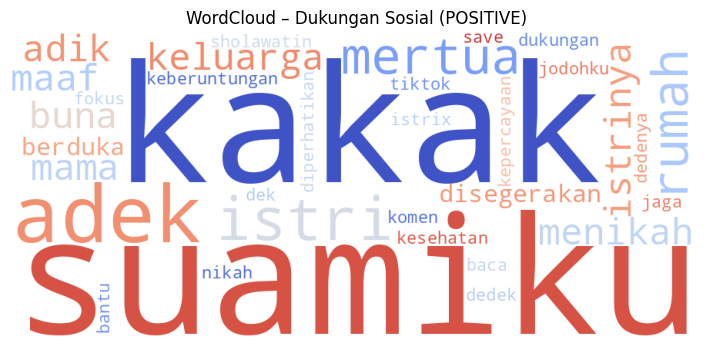

| Kata     |   Jumlah |
|:---------|---------:|
| suamiku  |        2 |
| kakak    |        2 |
| adek     |        2 |
| istri    |        1 |
| mertua   |        1 |
| rumah    |        1 |
| keluarga |        1 |
| istrinya |        1 |
| menikah  |        1 |
| adik     |        1 |

►  ASPEK: Perencanaan Keluarga  (37 kata)


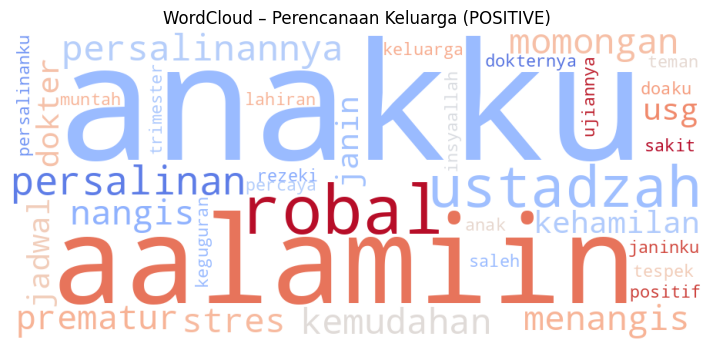

| Kata          |   Jumlah |
|:--------------|---------:|
| anakku        |        2 |
| aalamiin      |        1 |
| robal         |        1 |
| ustadzah      |        1 |
| persalinan    |        1 |
| persalinannya |        1 |
| kemudahan     |        1 |
| momongan      |        1 |
| menangis      |        1 |
| stres         |        1 |

►  ASPEK: Coping & Semangat  (15 kata)


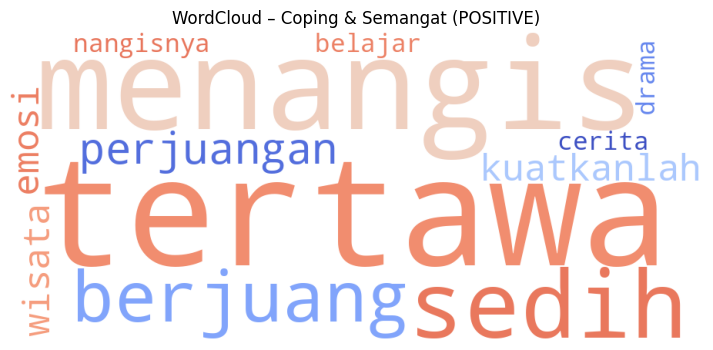

| Kata       |   Jumlah |
|:-----------|---------:|
| tertawa    |        2 |
| menangis   |        2 |
| sedih      |        2 |
| berjuang   |        1 |
| perjuangan |        1 |
| kuatkanlah |        1 |
| emosi      |        1 |
| wisata     |        1 |
| belajar    |        1 |
| drama      |        1 |

►  ASPEK: Spiritual/Religi  (14 kata)


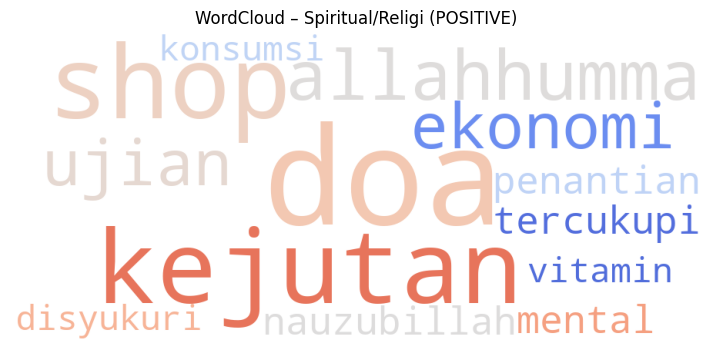

| Kata        |   Jumlah |
|:------------|---------:|
| doa         |        2 |
| shop        |        1 |
| kejutan     |        1 |
| allahhumma  |        1 |
| ekonomi     |        1 |
| ujian       |        1 |
| penantian   |        1 |
| mental      |        1 |
| tercukupi   |        1 |
| nauzubillah |        1 |

►  ASPEK: Keuangan & Karier  (2 kata)


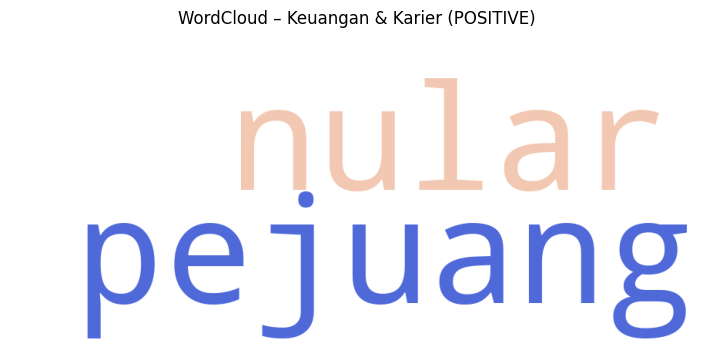

| Kata    |   Jumlah |
|:--------|---------:|
| nular   |        1 |
| pejuang |        1 |


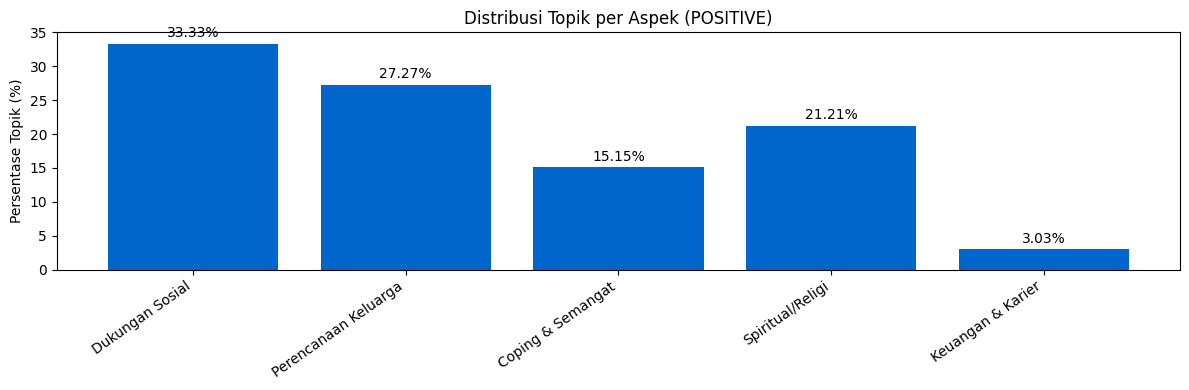


►  ASPEK: Konflik Pasangan  (27 kata)


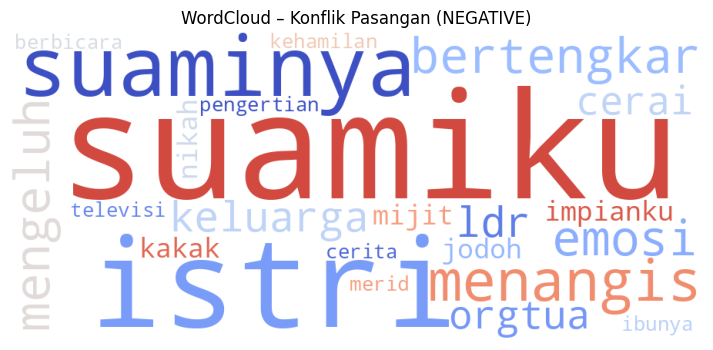

| Kata       |   Jumlah |
|:-----------|---------:|
| suamiku    |        3 |
| istri      |        2 |
| suaminya   |        2 |
| menangis   |        1 |
| bertengkar |        1 |
| emosi      |        1 |
| mengeluh   |        1 |
| keluarga   |        1 |
| ldr        |        1 |
| orgtua     |        1 |

►  ASPEK: Konflik Keluarga Besar  (12 kata)


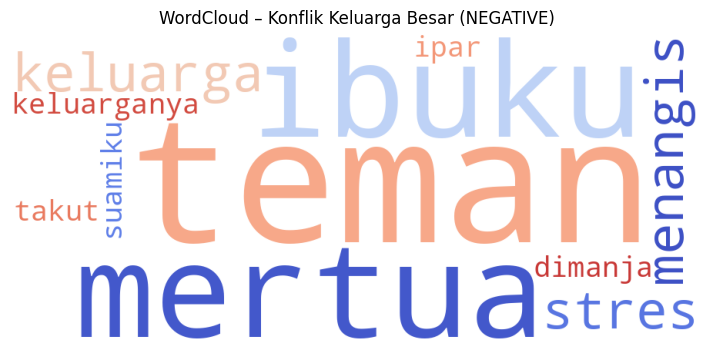

| Kata        |   Jumlah |
|:------------|---------:|
| teman       |        2 |
| ibuku       |        1 |
| mertua      |        1 |
| keluarga    |        1 |
| stres       |        1 |
| menangis    |        1 |
| keluarganya |        1 |
| suamiku     |        1 |
| ipar        |        1 |
| takut       |        1 |

►  ASPEK: Distress Emosi  (28 kata)


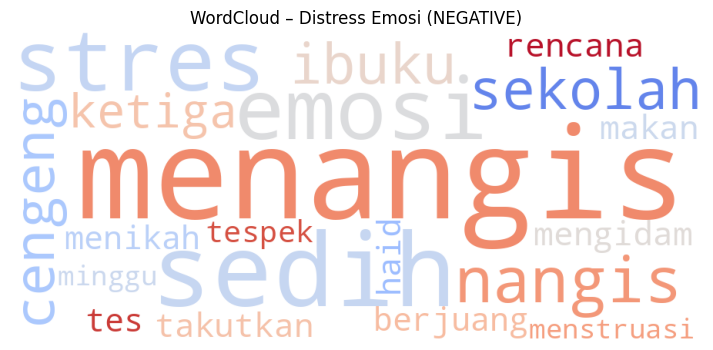

| Kata     |   Jumlah |
|:---------|---------:|
| menangis |        5 |
| sedih    |        3 |
| emosi    |        2 |
| stres    |        2 |
| nangis   |        1 |
| sekolah  |        1 |
| cengeng  |        1 |
| ibuku    |        1 |
| ketiga   |        1 |
| mengidam |        1 |

►  ASPEK: Kesehatan Kehamilan  (17 kata)


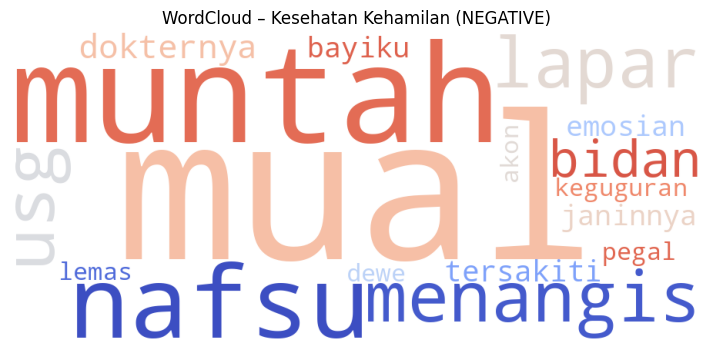

| Kata      |   Jumlah |
|:----------|---------:|
| mual      |        1 |
| muntah    |        1 |
| nafsu     |        1 |
| menangis  |        1 |
| lapar     |        1 |
| usg       |        1 |
| bidan     |        1 |
| dokternya |        1 |
| tersakiti |        1 |
| janinnya  |        1 |

►  ASPEK: Gangguan Tidur  (9 kata)


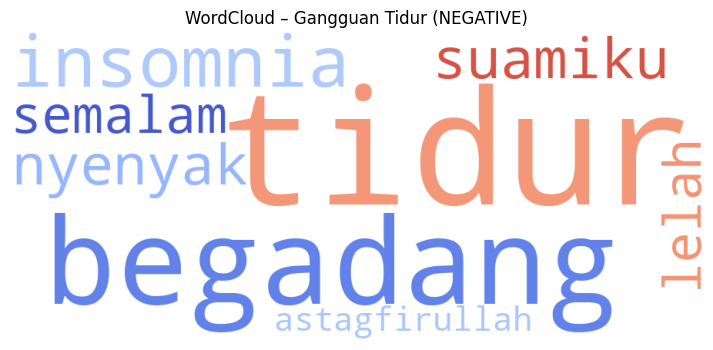

| Kata          |   Jumlah |
|:--------------|---------:|
| tidur         |        2 |
| begadang      |        1 |
| insomnia      |        1 |
| nyenyak       |        1 |
| suamiku       |        1 |
| semalam       |        1 |
| lelah         |        1 |
| astagfirullah |        1 |

►  ASPEK: Trauma & Fear  (12 kata)


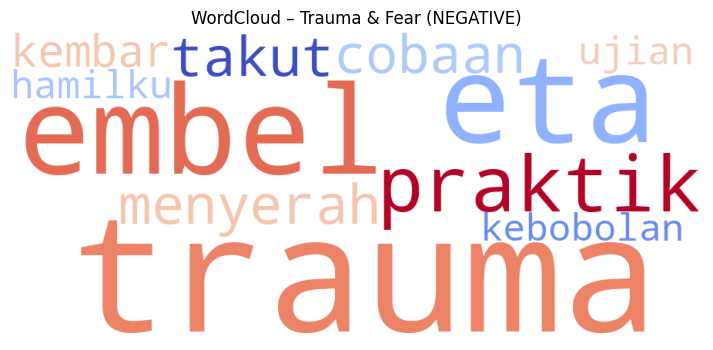

| Kata     |   Jumlah |
|:---------|---------:|
| trauma   |        2 |
| eta      |        1 |
| embel    |        1 |
| praktik  |        1 |
| menyerah |        1 |
| takut    |        1 |
| cobaan   |        1 |
| kembar   |        1 |
| hamilku  |        1 |
| ujian    |        1 |

►  ASPEK: Tekanan Ekonomi  (3 kata)


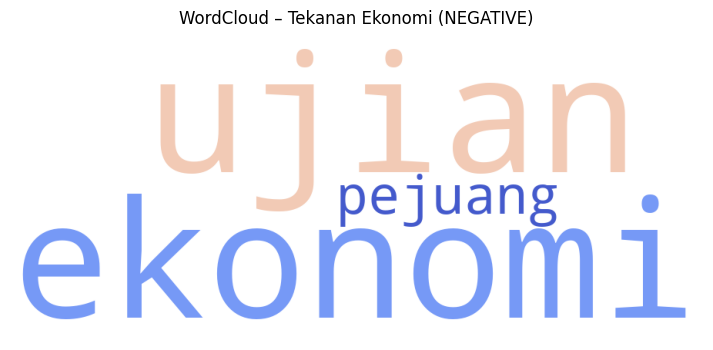

| Kata    |   Jumlah |
|:--------|---------:|
| ekonomi |        1 |
| ujian   |        1 |
| pejuang |        1 |


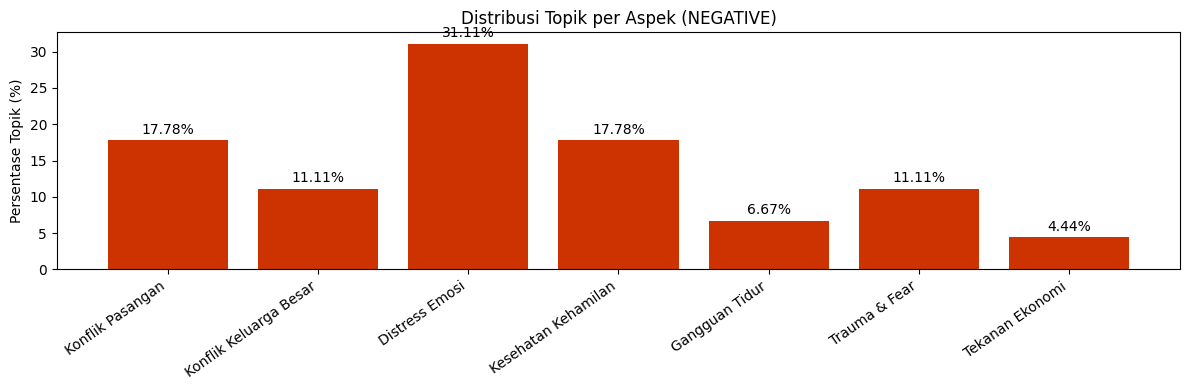

In [ ]:
# ==========================================================
# 0. IMPORT & KONFIGURASI
# ==========================================================
from collections import defaultdict, Counter
from pathlib import Path

import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 4)  # default lebar grafik


# ----------------------------------------------------------
# 2. UTIL: normalisasi & fuzzy-matching
# ----------------------------------------------------------
def _clean_token(tok: str) -> str:
    """Lower-case + keep alpha only (sederhana)."""
    return "".join(ch for ch in tok.lower() if ch.isalpha())
def fuzzy_aspect_score(top_words, aspect_keywords):
    """
    Kembalikan skor total untuk satu aspek berdasarkan top_words.
    """
    score = 0.0
    for w in top_words:
        best = max(fuzz.partial_ratio(w, ak) for ak in aspect_keywords)
        if best > 90:
            score += 1
        elif best > 75:
            score += 0.5
        elif best > 60:
            score += 0.2
    return score
def map_topic_to_aspect(keyword_list, aspect_dict):
    """
    Gunakan  fuzzy_aspect_score  untuk memilih aspek terbaik.
    """
    scores = {asp: fuzzy_aspect_score(keyword_list, kw)
              for asp, kw in aspect_dict.items()}
    # Ambil aspek dengan skor tertinggi (>0) jika ada
    best_asp = max(scores, key=scores.get)
    return best_asp if scores[best_asp] > 0 else "Lainnya"

# ----------------------------------------------------------
# 3. FUNGSIONAL: mapping + wordcloud + tabel
# ----------------------------------------------------------
def aspect_pipeline(
    topic_words: dict,          # {topic_id: [word, word, …]}
    aspect_dict: dict,          # {aspect: [seed_words]}
    sentiment_label: str,       # "POSITIVE"/"NEGATIVE"
    bar_color: str = "#1f77b4"  # warna default utk bar-chart
):
    """
    • Map setiap topik ke aspek menggunakan fuzzy match
    • Bangun daftar kata → frekuensi per aspek
    • Visualisasikan:
        – Wordcloud
        – Tabel frekuensi (top-10)
    • Return dict {aspect: Counter(words)} utk kebutuhan lain.
    """
    # ---------- 3.1 MAP TOPIK → ASPEK -------------
    aspect_wordbag = defaultdict(list)
    aspect_count_topics = Counter()

    for tid, words in topic_words.items():
        asp = map_topic_to_aspect(words, aspect_dict)
        aspect_wordbag[asp].extend(words)
        aspect_count_topics[asp] += 1

    # ---------- 3.2 WORDCLOUD + TABLE -------------
    for asp, words in aspect_wordbag.items():
        print(f"\n\u25BA  ASPEK: {asp}  ({len(words)} kata)")
        freq = Counter(map(_clean_token, words))
        # a) wordcloud
        wc = WordCloud(width=900, height=400,
                       background_color="white",
                       colormap="coolwarm").generate_from_frequencies(freq)
        plt.figure(figsize=(9,4)); plt.imshow(wc); plt.axis("off")
        plt.title(f"WordCloud – {asp} ({sentiment_label})")
        plt.show()

        # b) tabel frekuensi top-10
        top10 = freq.most_common(10)
        df = pd.DataFrame(top10, columns=["Kata","Jumlah"])
        print(df.to_markdown(index=False))

    # ---------- 3.3 BAR-CHART DISTRIBUSI TOPIK -----
    # konversi ke persen
    total = sum(aspect_count_topics.values())
    aspects, counts = zip(*aspect_count_topics.items())
    pct = [c/total*100 for c in counts]

    plt.figure(figsize=(12,4))
    plt.bar(aspects, pct, color=bar_color)
    plt.xticks(rotation=35, ha="right")
    for x, y in zip(aspects, pct):
        plt.text(x, y+0.5, f"{y:.2f}%", ha="center", va="bottom")
    plt.ylabel("Persentase Topik (%)")
    plt.title(f"Distribusi Topik per Aspek ({sentiment_label})")
    plt.tight_layout(); plt.show()

    return {asp: Counter(map(_clean_token, ws))
            for asp, ws in aspect_wordbag.items()}

# ==========================================================
# 4. CONTOH PEMANGGILAN
#    – asumsikan Anda sudah punya:
#       topic_words_pos  &  topic_words_neg
# ==========================================================
# --- POSITIVE ---
bag_pos = aspect_pipeline(
    topic_words=topic_words_pos,
    aspect_dict=ASPECT_KEYWORDS_POS,
    sentiment_label="POSITIVE",
    bar_color="#0066CC"
)

# --- NEGATIVE ---
bag_neg = aspect_pipeline(
    topic_words=topic_words_neg,
    aspect_dict=ASPECT_KEYWORDS_NEG,
    sentiment_label="NEGATIVE",
    bar_color="#CC3300"
)


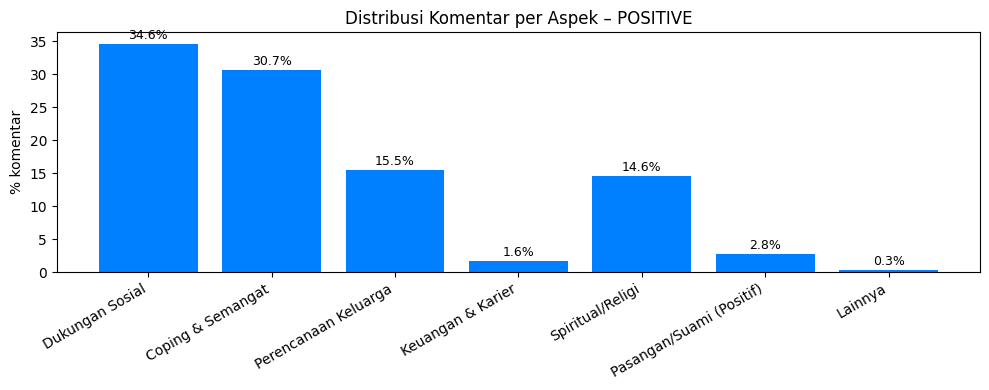


►  ASPEK: Dukungan Sosial  | 1285 komentar


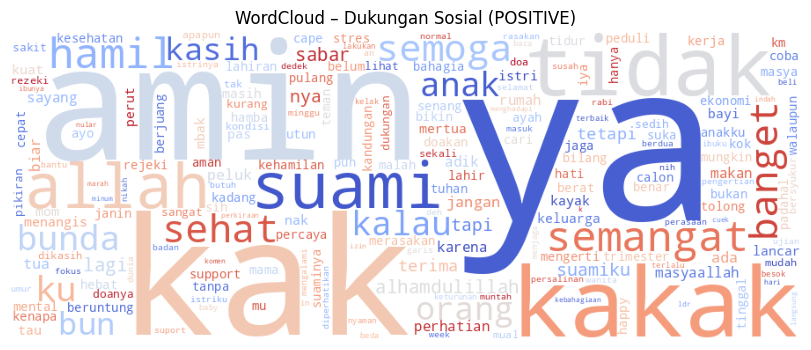

| Kata     |   Jumlah |
|:---------|---------:|
| ya       |      603 |
| kak      |      276 |
| amin     |      267 |
| kakak    |      237 |
| tidak    |      221 |
| suami    |      214 |
| allah    |      198 |
| semangat |      189 |
| hamil    |      188 |
| sehat    |      155 |
| banget   |      153 |
| semoga   |      149 |
| bunda    |      118 |
| ku       |      115 |
| anak     |      109 |

►  ASPEK: Coping & Semangat  | 1139 komentar


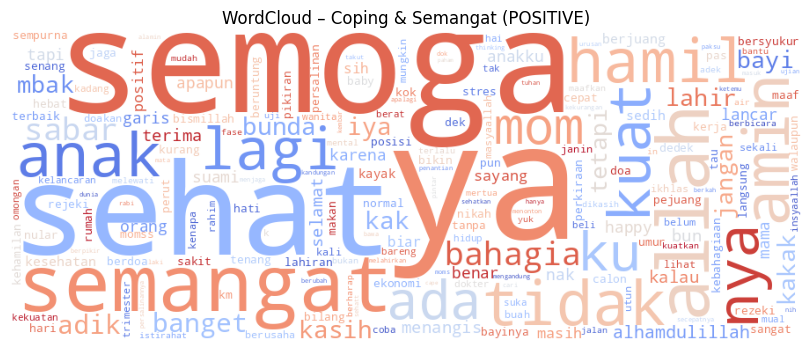

| Kata     |   Jumlah |
|:---------|---------:|
| ya       |      591 |
| semoga   |      480 |
| sehat    |      363 |
| semangat |      238 |
| allah    |      203 |
| amin     |      154 |
| tidak    |      145 |
| hamil    |      142 |
| anak     |      142 |
| lagi     |      130 |
| kuat     |      129 |
| nya      |      128 |
| ku       |      105 |
| ada      |      105 |
| mom      |       96 |

►  ASPEK: Perencanaan Keluarga  | 574 komentar


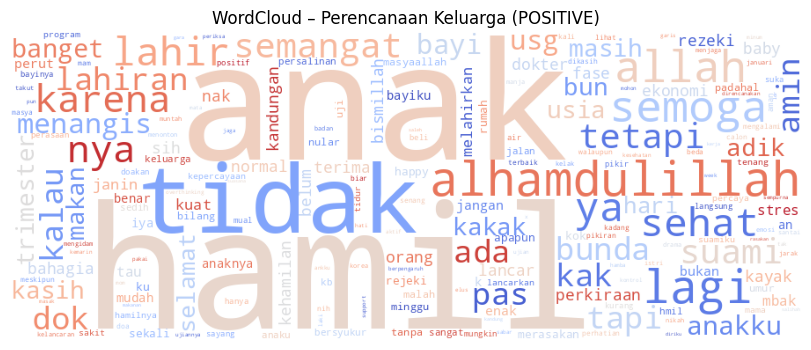

| Kata          |   Jumlah |
|:--------------|---------:|
| hamil         |      258 |
| anak          |      236 |
| tidak         |      138 |
| alhamdulillah |      129 |
| lagi          |      121 |
| allah         |      112 |
| semoga        |      111 |
| ya            |       92 |
| sehat         |       87 |
| lahir         |       87 |
| karena        |       79 |
| nya           |       78 |
| semangat      |       68 |
| tetapi        |       67 |
| suami         |       62 |

►  ASPEK: Keuangan & Karier  | 60 komentar


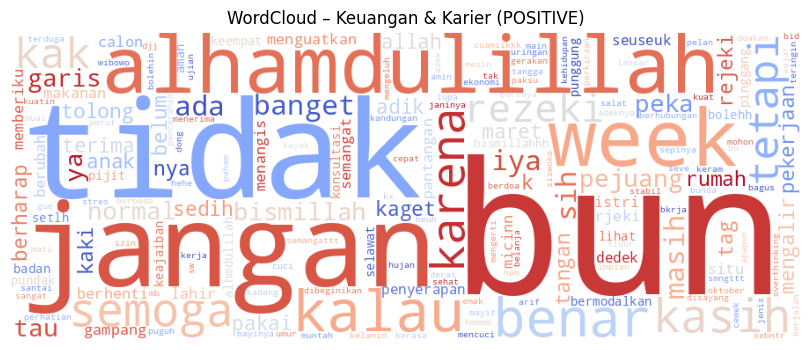

| Kata          |   Jumlah |
|:--------------|---------:|
| bun           |       30 |
| tidak         |       14 |
| jangan        |       10 |
| alhamdulillah |        7 |
| week          |        7 |
| kalau         |        7 |
| benar         |        6 |
| semoga        |        6 |
| karena        |        6 |
| kasih         |        6 |
| tetapi        |        5 |
| kak           |        5 |
| rezeki        |        5 |
| banget        |        4 |
| masih         |        4 |

►  ASPEK: Spiritual/Religi  | 541 komentar


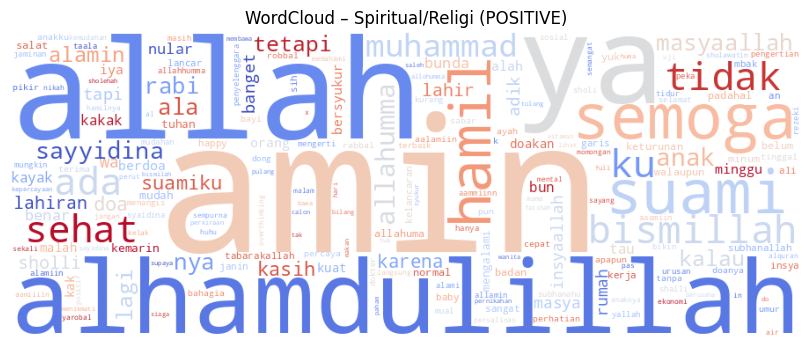

| Kata          |   Jumlah |
|:--------------|---------:|
| amin          |      265 |
| allah         |      198 |
| ya            |      157 |
| alhamdulillah |      135 |
| semoga        |       91 |
| suami         |       86 |
| hamil         |       76 |
| bismillah     |       56 |
| tidak         |       55 |
| ada           |       53 |
| sehat         |       52 |
| ku            |       51 |
| muhammad      |       49 |
| allahumma     |       34 |
| anak          |       30 |

►  ASPEK: Pasangan/Suami (Positif)  | 103 komentar


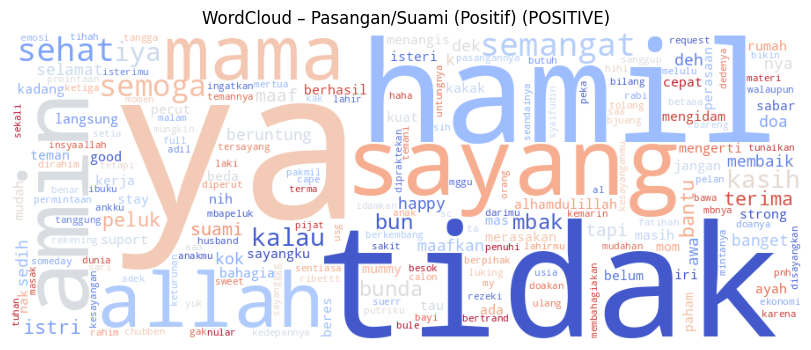

| Kata     |   Jumlah |
|:---------|---------:|
| ya       |       51 |
| tidak    |       49 |
| hamil    |       39 |
| sayang   |       24 |
| amin     |       24 |
| mama     |       15 |
| allah    |       15 |
| semangat |       14 |
| sehat    |       14 |
| semoga   |       12 |
| iya      |        9 |
| kalau    |        8 |
| kasih    |        8 |
| mbak     |        6 |
| bunda    |        6 |


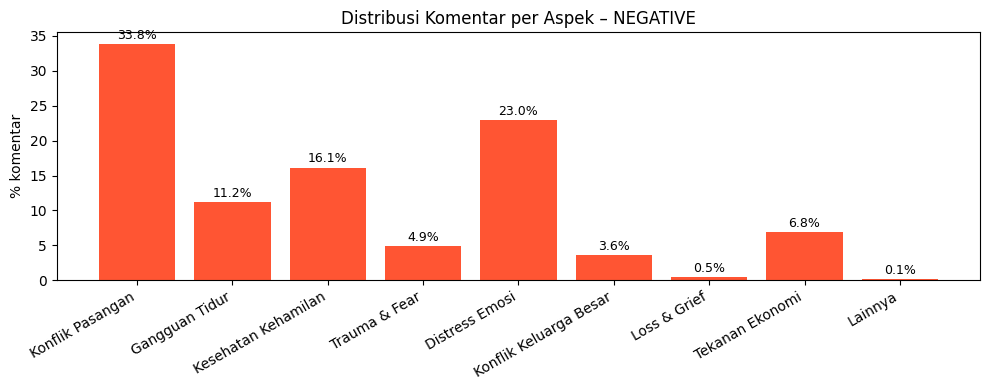


►  ASPEK: Konflik Pasangan  | 2130 komentar


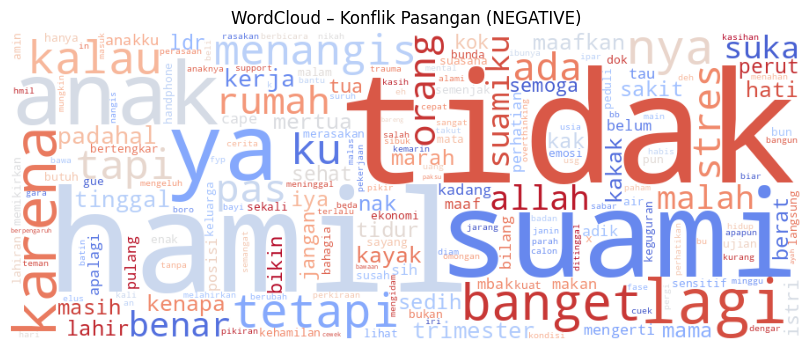

| Kata     |   Jumlah |
|:---------|---------:|
| tidak    |     1174 |
| hamil    |      987 |
| suami    |      851 |
| ya       |      466 |
| anak     |      411 |
| lagi     |      361 |
| karena   |      327 |
| banget   |      295 |
| nya      |      276 |
| tetapi   |      260 |
| kalau    |      244 |
| menangis |      243 |
| ku       |      241 |
| tapi     |      229 |
| pas      |      207 |

►  ASPEK: Gangguan Tidur  | 703 komentar


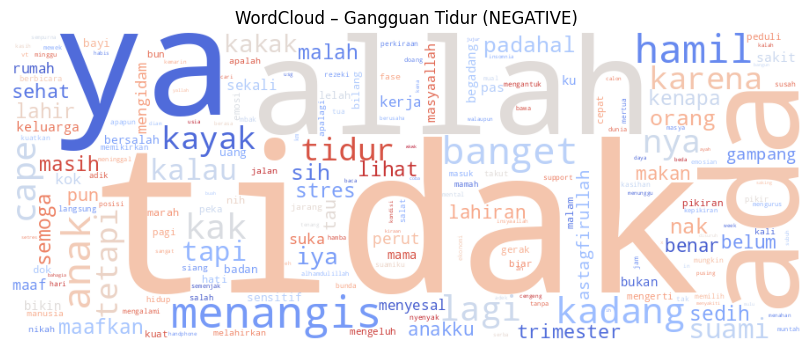

| Kata     |   Jumlah |
|:---------|---------:|
| tidak    |      408 |
| ya       |      315 |
| allah    |      245 |
| ada      |      243 |
| menangis |      153 |
| anak     |      123 |
| hamil    |      123 |
| banget   |      110 |
| kadang   |      102 |
| lagi     |       90 |
| cape     |       89 |
| kak      |       87 |
| nya      |       79 |
| tidur    |       75 |
| karena   |       75 |

►  ASPEK: Kesehatan Kehamilan  | 1017 komentar


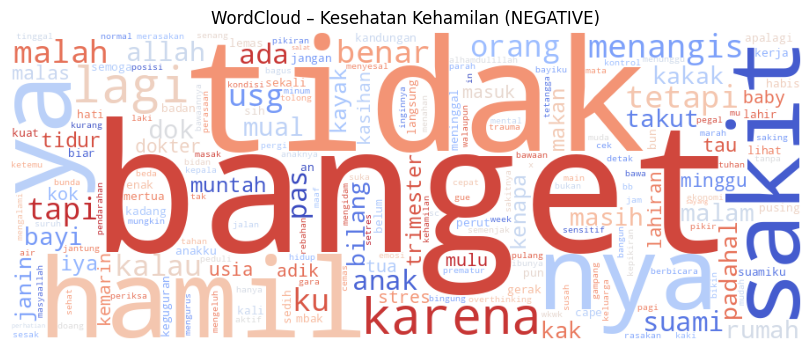

| Kata     |   Jumlah |
|:---------|---------:|
| banget   |      360 |
| tidak    |      334 |
| hamil    |      224 |
| ya       |      199 |
| nya      |      188 |
| sakit    |      171 |
| karena   |      136 |
| lagi     |      133 |
| menangis |      111 |
| benar    |      108 |
| malah    |      106 |
| tetapi   |      106 |
| ku       |      101 |
| usg      |       99 |
| tapi     |       96 |

►  ASPEK: Trauma & Fear  | 311 komentar


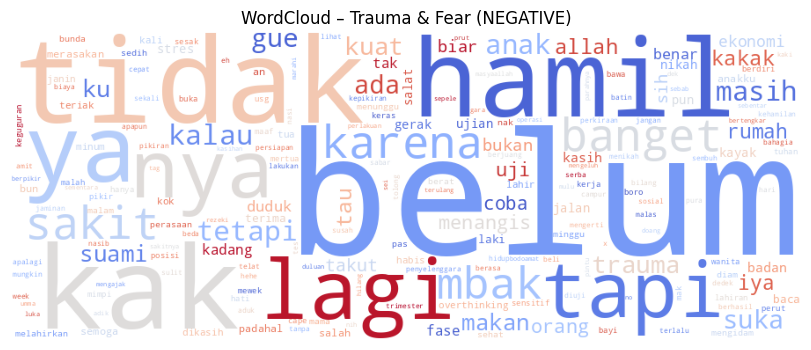

| Kata   |   Jumlah |
|:-------|---------:|
| belum  |       88 |
| tidak  |       73 |
| kak    |       69 |
| hamil  |       62 |
| ya     |       45 |
| lagi   |       44 |
| nya    |       42 |
| tapi   |       38 |
| banget |       33 |
| karena |       33 |
| sakit  |       33 |
| mbak   |       32 |
| tetapi |       31 |
| kalau  |       31 |
| anak   |       30 |

►  ASPEK: Distress Emosi  | 1446 komentar


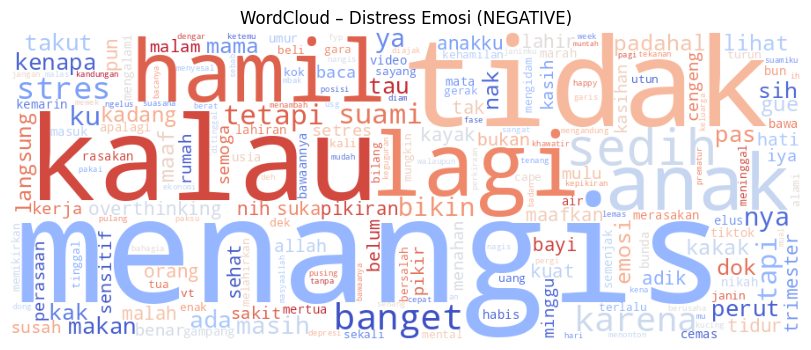

| Kata     |   Jumlah |
|:---------|---------:|
| menangis |      673 |
| tidak    |      448 |
| kalau    |      401 |
| lagi     |      360 |
| hamil    |      338 |
| anak     |      275 |
| sedih    |      236 |
| banget   |      212 |
| karena   |      195 |
| stres    |      162 |
| suami    |      129 |
| tetapi   |      129 |
| tapi     |      123 |
| ku       |      113 |
| nya      |      103 |

►  ASPEK: Konflik Keluarga Besar  | 224 komentar


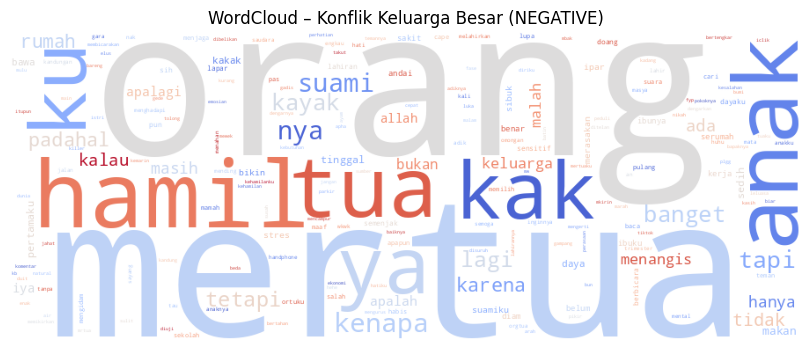

| Kata   |   Jumlah |
|:-------|---------:|
| orang  |       62 |
| mertua |       55 |
| hamil  |       43 |
| anak   |       40 |
| tua    |       38 |
| kak    |       36 |
| ya     |       36 |
| ku     |       35 |
| kenapa |       33 |
| suami  |       30 |
| nya    |       30 |
| tapi   |       26 |
| banget |       25 |
| kayak  |       25 |
| lagi   |       24 |

►  ASPEK: Loss & Grief  | 30 komentar


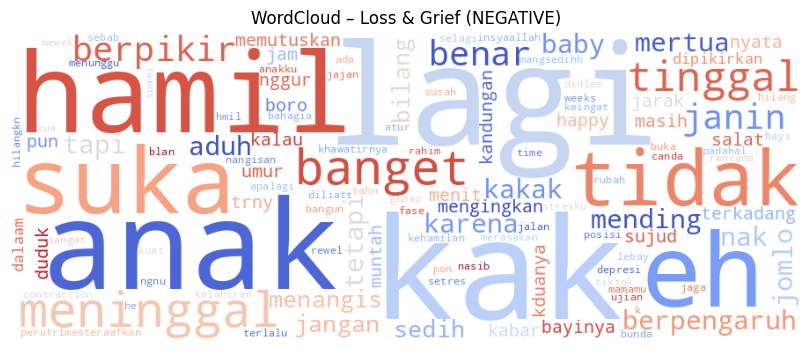

| Kata        |   Jumlah |
|:------------|---------:|
| kak         |        9 |
| lagi        |        9 |
| anak        |        7 |
| hamil       |        6 |
| eh          |        5 |
| suka        |        4 |
| tidak       |        4 |
| meninggal   |        3 |
| banget      |        3 |
| tinggal     |        3 |
| berpikir    |        2 |
| janin       |        2 |
| benar       |        2 |
| berpengaruh |        2 |
| mending     |        2 |

►  ASPEK: Tekanan Ekonomi  | 431 komentar


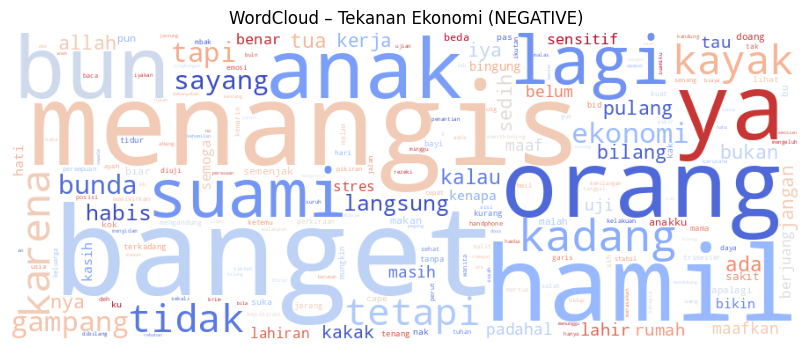

| Kata     |   Jumlah |
|:---------|---------:|
| banget   |      119 |
| menangis |      104 |
| hamil    |       90 |
| orang    |       89 |
| ya       |       86 |
| bun      |       74 |
| anak     |       68 |
| lagi     |       56 |
| suami    |       56 |
| kadang   |       48 |
| karena   |       43 |
| kayak    |       42 |
| tidak    |       39 |
| tetapi   |       38 |
| gampang  |       38 |


In [ ]:
# =========================================================
# 0. IMPORT DASAR
# =========================================================
from collections import Counter, defaultdict
from pathlib import Path
import re, string

import pandas as pd
import matplotlib.pyplot as plt
from rapidfuzz import fuzz, process
from wordcloud import WordCloud

plt.rcParams["figure.figsize"] = (12,4)

# =========================================================
# 1. DEFINISI ASPEK & SEED KEYWORDS  (pakai dict yg sdh fix)
# =========================================================
# ASPECT_KEYWORDS_POS   = {...}   # <-- paste dict POS sebelumnya
# ASPECT_KEYWORDS_NEG   = {...}   # <-- paste dict NEG sebelumnya

# =========================================================
# 2. PRE-PROCESS UTIL
# =========================================================
_punct_table = str.maketrans("","", string.punctuation)

def normalize(text: str) -> list:
    """
    Bersihkan teks: lower-case, hapus tanda baca & angka,
    keluarkan list token unik (tanpa stopword dasar).
    """
    text = text.lower().translate(_punct_table)
    tokens = re.findall(r"[a-zA-Z]+", text)     # huruf saja
    return tokens

# =========================================================
# 3. FUNGSI MAP KOMENTAR ➜ ASPEK
# =========================================================
def map_comment(tokens, aspect_dict, t_high=85, t_mid=70):
    """
    Beri label aspek pada 1 komentar via fuzzy ratio:
      – Cari kecocokan terbaik setiap token ke seluruh keywords aspek
      – Bobot 1 kalau rasio ≥ t_high
      – Bobot 0.5 kalau rasio ≥ t_mid
    Kembalikan aspek skor tertinggi (atau 'Lainnya' jika 0).
    """
    score = Counter()
    for tok in tokens:
        for asp, kw in aspect_dict.items():
            best = process.extractOne(tok, kw, scorer=fuzz.partial_ratio)
            if not best:              # tidak ada kandidat
                continue
            ratio = best[1]
            if ratio >= t_high:
                score[asp] += 1
            elif ratio >= t_mid:
                score[asp] += .5
    if not score:
        return "Lainnya"
    return score.most_common(1)[0][0]

# =========================================================
# 4. PIPELINE DATASET → VISUALISASI
# =========================================================
def dataset_aspect_analysis(df, text_col, aspect_dict,
                            sentiment_label="POS", bar_color="#1f77b4"):
    """
    • df[text_col]  : kolom string komentar
    • aspect_dict   : dict {aspect: [seed words]}
    • Buat:
        – bar-chart distribusi komentar per aspek
        – word-cloud & tabel frekuensi kata (top-N) tiap aspek
    • return dict{aspect:Counter}
    """
    aspect_counters  = defaultdict(Counter)  # aspek → Counter(kata)
    aspect_doc_count = Counter()             # aspek → #dok

    for txt in df[text_col].dropna():
        toks = normalize(txt)
        if not toks:
            continue
        asp = map_comment(toks, aspect_dict)
        aspect_doc_count[asp] += 1
        aspect_counters[asp].update(toks)

    # 4-A  BAR CHART distribusi dokumen
    total = sum(aspect_doc_count.values())
    aspects = list(aspect_doc_count)
    pct     = [aspect_doc_count[a]/total*100 for a in aspects]

    plt.figure(figsize=(10,4))
    plt.bar(aspects, pct, color=bar_color)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("% komentar")
    plt.title(f"Distribusi Komentar per Aspek – {sentiment_label}")
    for x,y in zip(aspects,pct):
        plt.text(x, y+0.3, f"{y:.1f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout(); plt.show()

    # 4-B  WORD-CLOUD & TABEL FREKUENSI per aspek
    for asp, counter in aspect_counters.items():
        if asp=="Lainnya":                # lewati aspek sisa
            continue
        print(f"\n\u25BA  ASPEK: {asp}  | {aspect_doc_count[asp]} komentar")
        ## wordcloud
        wc = WordCloud(width=900,height=350,
                       background_color="white",
                       colormap="coolwarm").generate_from_frequencies(counter)
        plt.imshow(wc); plt.axis("off")
        plt.title(f"WordCloud – {asp} ({sentiment_label})"); plt.show()

        ## tabel frekuensi top-15
        freq_df = (pd.DataFrame(counter.most_common(15),
                                columns=["Kata","Jumlah"]))
        print(freq_df.to_markdown(index=False))
    return aspect_counters, aspect_doc_count

# =========================================================
# 5. LOAD DATA & JALANKAN
# =========================================================
# — positif —
df_pos = pd.read_csv(
    "/content/drive/MyDrive/TA den/Dataset untuk topic modelling/final_positif_dataset_keep_stopword.csv"
)
# — negatif —
df_neg = pd.read_csv(
    "/content/drive/MyDrive/TA den/Dataset untuk topic modelling/final_negatif_dataset_keep_stopword.csv"
)

# --------- Run ----------
bag_pos, doc_pos = dataset_aspect_analysis(
    df=df_pos, text_col="text",
    aspect_dict=ASPECT_KEYWORDS_POS,
    sentiment_label="POSITIVE", bar_color="#0080ff"
)

bag_neg, doc_neg = dataset_aspect_analysis(
    df=df_neg, text_col="text",
    aspect_dict=ASPECT_KEYWORDS_NEG,
    sentiment_label="NEGATIVE", bar_color="#ff5533"
)


## Fuzzy Match + Embedding Indobert

In [ ]:
# ╓───────────────────────────────────────────────────────────────╖
# ║  0.  LIBRARIES & DEPENDENCY CHECK                            ║
# ╙───────────────────────────────────────────────────────────────╜
!pip install -q rapidfuzz wordcloud

import re, string, json, math, collections
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from rapidfuzz import fuzz
from sentence_transformers import SentenceTransformer, util

# ╓───────────────────────────────────────────────────────────────╖
# ║  1.  LOAD DATA (ubah path bila perlu)                        ║
# ╙───────────────────────────────────────────────────────────────╜
# PATH_POS = "/content/drive/MyDrive/TA den/Dataset untuk topic modelling/final_positif_dataset_keep_stopword.csv"
# PATH_NEG = "/content/drive/MyDrive/TA den/Dataset untuk topic modelling/final_negatif_dataset_keep_stopword.csv"

df_pos = pd.read_csv(PATH_POS)
df_neg = pd.read_csv(PATH_NEG)

pos_texts = df_pos["text"].dropna().astype(str).tolist()
neg_texts = df_neg["text"].dropna().astype(str).tolist()

print(f"Loaded {len(pos_texts):,} POS dan {len(neg_texts):,} NEG dokumen")

# ╓───────────────────────────────────────────────────────────────╖
# ║  2.  BASIC TOKEN-CLEAN FUNCTION                              ║
# ╙───────────────────────────────────────────────────────────────╜
# BASE_STOPWORDS = {
#   "tidak","banget","lagi","ya","nya","ada","pas","benar","ku","kak","tapi","tetapi",
#   "bikin","amin","aminkan","allahumma","sayyidina","muhammad","nur","kok","iya","nak",
#   "semoga","tak","mom","mbak","bunda","dok","an","sih","bun","kalau","orang","karena",
#   "kenapa","malah","masih","belum","kadang","padahal","tau","kayak","suami","hamil","x","r"
# }

import re, string

TOKEN_RE = re.compile(r"\w+")          # ambil token alfabet/angka apa adanya

def clean_tokens(text:str):
    """
    • Ekstrak token apa adanya (tidak di-lowercase)
    • Buang token yang ada di BASE_STOPWORDS (stop-word dasar)
    • Tidak ada stemming, lemmatisasi, dsb.
    """
    tokens = TOKEN_RE.findall(text)     # ['Aku','Lagi','Mual',...]
    return [t for t in tokens if t.lower() not in BASE_STOPWORDS]


# ╓───────────────────────────────────────────────────────────────╖
# ║  4.  ENCODER + PRE-COMPUTE EMBEDDINGS                        ║
# ╙───────────────────────────────────────────────────────────────╜

embedder = SentenceTransformer("firqaaa/indo-sentence-bert-base")

def build_aspect_vecs(asp_dict):
    return {
        asp: embedder.encode(" ".join(kws), normalize_embeddings=True)
        for asp, kws in asp_dict.items()
    }
print('\n=== [ASPECT EMBEDDING POSITIF] ===')
start_asp_pos = time.time()
ASP_VEC_POS = build_aspect_vecs(ASPECT_KEYWORDS_POS)
end_asp_pos = time.time()
print(f"Waktu proses embedding aspek POSITIF: {seconds_to_mmss(end_asp_pos - start_asp_pos)}")

print('\n=== [ASPECT EMBEDDING NEGATIF] ===')
start_asp_neg = time.time()
ASP_VEC_NEG = build_aspect_vecs(ASPECT_KEYWORDS_NEG)
end_asp_neg = time.time()
print(f"Waktu proses embedding aspek NEGATIF: {seconds_to_mmss(end_asp_neg - start_asp_neg)}")
# ╓───────────────────────────────────────────────────────────────╖
# ║  5.  ASPECT MAPPING FUNCTION                                 ║
# ╙───────────────────────────────────────────────────────────────╜
def map_aspect(comment:str,
               asp_dict:dict,
               asp_vec :dict,
               thr:float = .35,
               w_cos:float=.6,
               w_fuzz:float=.4):
    """
    • Vector cosine + fuzzy; kembalikan aspek terbaik atau 'Lainnya'
    """
    toks = clean_tokens(comment)
    if not toks:
        return "Lainnya"
    sent_vec = embedder.encode(" ".join(toks), normalize_embeddings=True)

    best_asp, best_score = "Lainnya", 0.0
    for asp, vec in asp_vec.items():
        cos  = float(util.cos_sim(sent_vec, vec))
        fuzz_sc = max(fuzz.partial_ratio(" ".join(toks), kw) for kw in asp_dict[asp]) / 100
        score = w_cos*cos + w_fuzz*fuzz_sc
        if score > best_score:
            best_asp, best_score = asp, score
    return best_asp if best_score >= thr else "Lainnya"

# ╓───────────────────────────────────────────────────────────────╖
# ║  6.  APPLY TO DATA                                           ║
# ╙───────────────────────────────────────────────────────────────╜
df_pos["aspect"] = df_pos["text"].apply(map_aspect,
                                        args=(ASPECT_KEYWORDS_POS, ASP_VEC_POS))
df_neg["aspect"] = df_neg["text"].apply(map_aspect,
                                        args=(ASPECT_KEYWORDS_NEG, ASP_VEC_NEG))



Loaded 3,717 POS dan 6,300 NEG dokumen


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


=== [ASPECT EMBEDDING POSITIF] ===
Waktu proses embedding aspek POSITIF: 00:01

=== [ASPECT EMBEDDING NEGATIF] ===
Waktu proses embedding aspek NEGATIF: 00:00


In [ ]:
# ── 6-a. Word-Cloud + Tabel Frekuensi ──────────────────────────
import collections, matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# -----------------------------------------------------------
#  VISUALISASI WORD-CLOUD + TOP-10 FREKUENSI (warna-warni)
# -----------------------------------------------------------
def visual_aspect(df, asp_dict, tag):
    """
    • df        : DataFrame yang sudah berisi kolom 'text' dan 'aspect'
    • asp_dict  : kamus {aspect:[keyword,…]}  (hanya dipakai untuk loop nama aspek)
    • tag       : string penanda 'POS' / 'NEG' (ditampilkan di judul)
    """
    for asp in asp_dict:
        subset = df[df["aspect"] == asp]["text"]
        if subset.empty:
            continue

        # --- hitung frekuensi token ---
        tokens = [tok for txt in subset for tok in clean_tokens(txt)]
        freq   = collections.Counter(tokens)

        # ---------- WORD-CLOUD ----------
        wc = WordCloud(
                width             = 600,
                height            = 400,
                background_color  = "white",
                colormap          = "tab20"      # <─ palet multi-warna
             ).generate_from_frequencies(freq)

        plt.figure(figsize=(5, 3.5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud – {asp} ({tag})")
        plt.show()

        # ---------- TABLE TOP-10 ----------
        top_df = (pd.DataFrame(freq.items(), columns=["Kata", "Jumlah"])
                    .sort_values("Jumlah", ascending=False)
                    .head(10))
        print(f"\nTop-10 kata – {asp} ({tag})")
        display(top_df.style.hide(axis="index"))


In [ ]:
# -----------------------------------------------------------
#  BAR CHART DISTRIBUSI ASPEK   (POS atau NEG, terpisah)
# -----------------------------------------------------------
def plot_aspect_distribution(df, tag, color="steelblue"):
    """
    df   : DataFrame  (wajib sudah ada kolom 'aspect')
    tag  : judul penanda, mis. 'POSITIF' / 'NEGATIF'
    """
    # Persentase per-aspek
    ser = (df["aspect"].value_counts(normalize=True) * 100).sort_values(ascending=False)

    # ----- plot -----
    ax   = ser.plot(kind="bar", color=color, figsize=(10,4.5), zorder=2)
    ymax = ser.max()

    # beri ruang 15 % di atas kolom tertinggi
    ax.set_ylim(0, ymax * 1.15)

    # label + offset
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:.1f}%",             # teks
                    (p.get_x() + p.get_width()/2, height + ymax*0.02),  # naik 2 % dari puncak kolom
                    ha='center', va='bottom', fontsize=9)

    ax.set_xlabel("Aspect")
    ax.set_ylabel("Persentase (%)")
    ax.set_title(f"Persentase Data per Aspect ({tag})")
    ax.grid(axis="y", alpha=.3, zorder=0)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


==========  SENTIMEN POSITIF  ==========


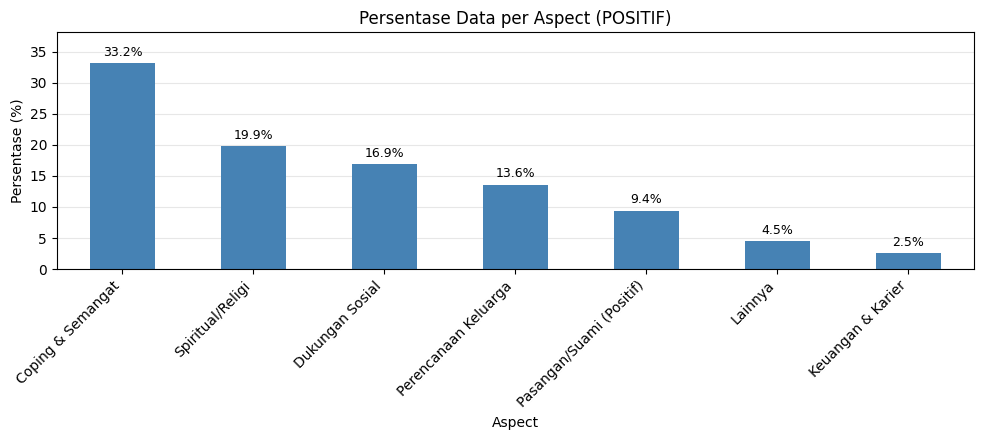

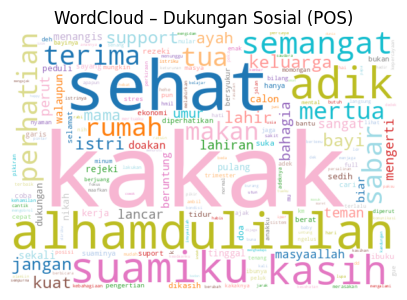


Top-10 kata – Dukungan Sosial (POS)


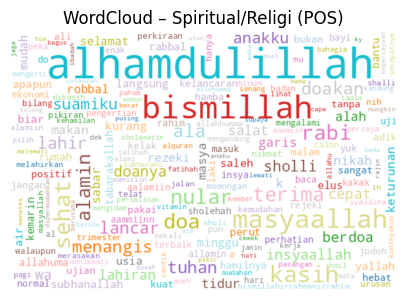


Top-10 kata – Spiritual/Religi (POS)


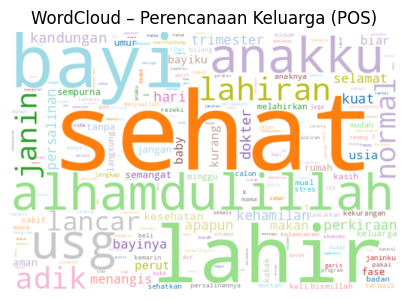


Top-10 kata – Perencanaan Keluarga (POS)


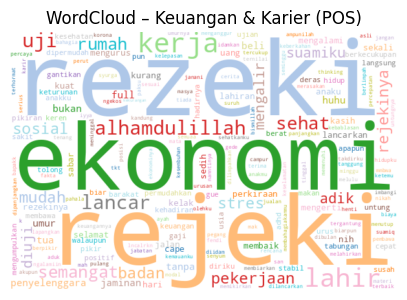


Top-10 kata – Keuangan & Karier (POS)


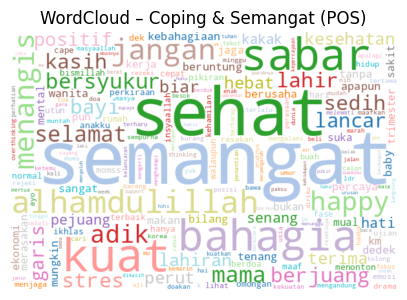


Top-10 kata – Coping & Semangat (POS)


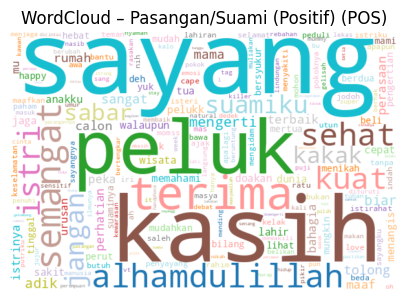


Top-10 kata – Pasangan/Suami (Positif) (POS)



==========  SENTIMEN NEGATIF  ==========


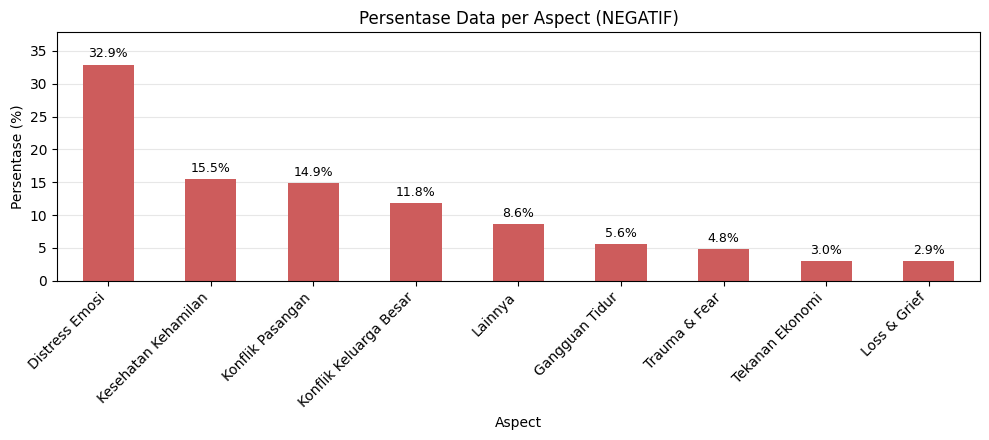

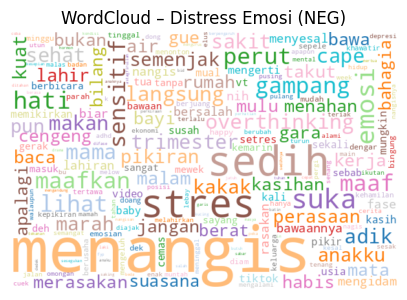


Top-10 kata – Distress Emosi (NEG)


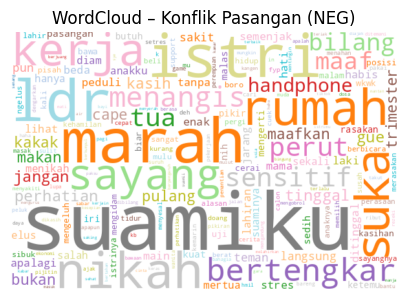


Top-10 kata – Konflik Pasangan (NEG)


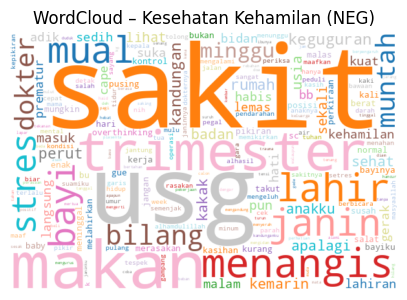


Top-10 kata – Kesehatan Kehamilan (NEG)


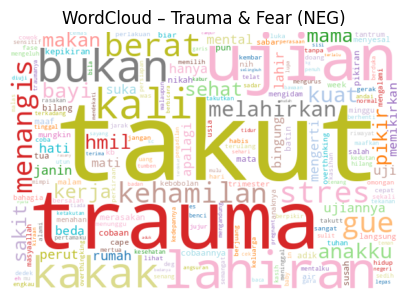


Top-10 kata – Trauma & Fear (NEG)


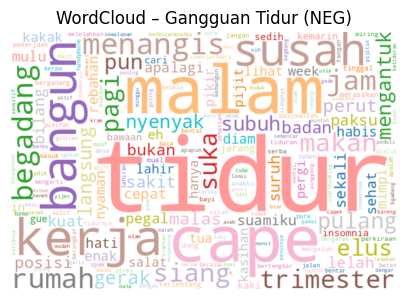


Top-10 kata – Gangguan Tidur (NEG)


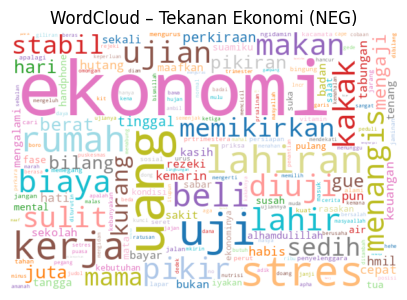


Top-10 kata – Tekanan Ekonomi (NEG)


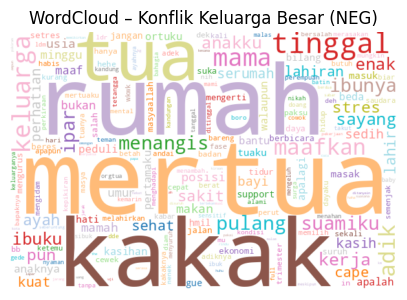


Top-10 kata – Konflik Keluarga Besar (NEG)


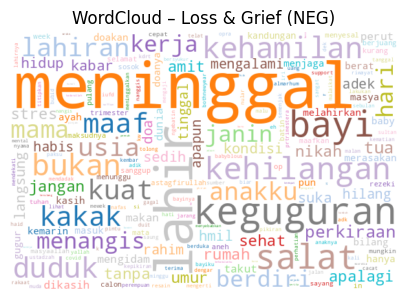


Top-10 kata – Loss & Grief (NEG)


In [ ]:
# ─── 7. JALANKAN VISUALISASI ──────────────────────────────────
print("==========  SENTIMEN POSITIF  ==========")
plot_aspect_distribution(df_pos, "POSITIF", color="steelblue")
visual_aspect(df_pos, ASPECT_KEYWORDS_POS, "POS")

print("\n==========  SENTIMEN NEGATIF  ==========")
plot_aspect_distribution(df_neg, "NEGATIF", color="indianred")
visual_aspect(df_neg, ASPECT_KEYWORDS_NEG, "NEG")
